## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [6]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
train, test = keras.datasets.cifar10.load_data()

In [8]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [9]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 
MOMENTUM = 0.95

In [12]:
# 載入 Callbacks
"""
# 載入 Callbacks, 並設定監控目標為 validation loss
"""
from keras.callbacks import ReduceLROnPlateau

SGD = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95)
Adam = keras.optimizers.Adam(lr=LEARNING_RATE)
RMSprop = keras.optimizers.RMSprop(lr=LEARNING_RATE)

optimizer_set = [SGD, Adam, RMSprop]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.3, 0.5]
reduce_lr_patient = [5, 15, 25]

In [13]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )
    
    if 'SGD' in str(optim):
        opt = 'SGD'
    elif 'Adam' in str(optim):
        opt = 'Adam'
    else:
        opt = 'RMSprop'
    print(opt)
    # Collect results
    exp_name_tag = ("opt-%s,factor-%s,patient-%s" % (opt, str(reduce_factor),str(reduce_patient)))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2739 - accuracy: 0.5590 - val_loss: 1.4755 - val_accuracy: 0.4795
Epoch 12/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2474 - accuracy: 0.5683 - val_loss: 1.4768 - val_accuracy: 0.4780
Epoch 13/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2231 - accuracy: 0.5765 - val_loss: 1.4608 - val_accuracy: 0.4855
Epoch 14/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.1969 - accuracy: 0.5866 - val_loss: 1.4610 - val_accuracy: 0.4863
Epoch 15/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.1733 - accuracy: 0.5959 - val_loss: 1.4607 - val_accuracy: 0.4855
Epoch 16/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.1505 - accuracy: 0.6047 - val_loss: 1.4560 - val_accuracy: 0.4876
Epoch 17/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.1284 - accuracy: 0.6137 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 35us/step - loss: 2.2319 - accuracy: 0.2597 - val_loss: 2.1329 - val_accuracy: 0.2092
Epoch 2/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.7396 - accuracy: 0.3945 - val_loss: 1.9643 - val_accuracy: 0.3098
Epoch 3/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.6170 - accuracy: 0.4326 - val_loss: 1.8256 - val_accuracy: 0.3606
Epoch 4/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5445 - accuracy: 0.4578 - val_loss: 1.7183 - val_accuracy: 0.4012
Epoch 5/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4912 - accuracy: 0.4781 - val_loss: 1.6267 - val_accuracy: 0.4358
Epoch 6/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.4446 - accuracy: 0.4937 - val_loss: 1.5781 - val_accuracy: 0.4516
Epoch 7/25
50000/50000 [==============================] - 2s 31us/st

50000/50000 [==============================] - 2s 31us/step - loss: 1.3339 - accuracy: 0.5388 - val_loss: 1.5431 - val_accuracy: 0.4621
Epoch 21/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3204 - accuracy: 0.5448 - val_loss: 1.5406 - val_accuracy: 0.4618
Epoch 22/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3079 - accuracy: 0.5487 - val_loss: 1.5338 - val_accuracy: 0.4635
Epoch 23/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2954 - accuracy: 0.5529 - val_loss: 1.5326 - val_accuracy: 0.4675
Epoch 24/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.2819 - accuracy: 0.5563 - val_loss: 1.5245 - val_accuracy: 0.4681
Epoch 25/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2702 - accuracy: 0.5631 - val_loss: 1.5256 - val_accuracy: 0.4692
SGD
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 25
Model: "model_6"
____________________________________________

Epoch 5/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.6814 - accuracy: 0.4161 - val_loss: 1.7981 - val_accuracy: 0.3664
Epoch 6/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.6346 - accuracy: 0.4323 - val_loss: 1.7321 - val_accuracy: 0.3901
Epoch 7/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5978 - accuracy: 0.4443 - val_loss: 1.6800 - val_accuracy: 0.4100
Epoch 8/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5665 - accuracy: 0.4563 - val_loss: 1.6557 - val_accuracy: 0.4202
Epoch 9/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5385 - accuracy: 0.4650 - val_loss: 1.6347 - val_accuracy: 0.4299
Epoch 10/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5133 - accuracy: 0.4749 - val_loss: 1.6176 - val_accuracy: 0.4344
Epoch 11/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4906 - accuracy: 0.4840 - val_loss:

50000/50000 [==============================] - 2s 31us/step - loss: 1.2852 - accuracy: 0.5548 - val_loss: 1.5264 - val_accuracy: 0.4675
SGD
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 25
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
__________________________________________________________

50000/50000 [==============================] - 2s 34us/step - loss: 0.9767 - accuracy: 0.6640 - val_loss: 1.5464 - val_accuracy: 0.4595
Epoch 10/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.9285 - accuracy: 0.6827 - val_loss: 1.4079 - val_accuracy: 0.5049
Epoch 11/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.9079 - accuracy: 0.6907 - val_loss: 1.3632 - val_accuracy: 0.5201
Epoch 12/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.8901 - accuracy: 0.6978 - val_loss: 1.3527 - val_accuracy: 0.5230
Epoch 13/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.8746 - accuracy: 0.7033 - val_loss: 1.3627 - val_accuracy: 0.5248
Epoch 14/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.8583 - accuracy: 0.7095 - val_loss: 1.3317 - val_accuracy: 0.5329
Epoch 15/25
50000/50000 [==============================] - 2s 34us/step - loss: 0.8451 - accuracy: 0.7140 - val_loss: 1.3289

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.1276 - accuracy: 0.2849 - val_loss: 2.1362 - val_accuracy: 0.1933
Epoch 2/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.7682 - accuracy: 0.3846 - val_loss: 1.9867 - val_accuracy: 0.2939
Epoch 3/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.6706 - accuracy: 0.4168 - val_loss: 1.8581 - val_accuracy: 0.3582
Epoch 4/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.6108 - accuracy: 0.4370 - val_loss: 1.7653 - val_accuracy: 0.3833
Epoch 5/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.5679 - accuracy: 0.4538 - val_loss: 1.7020 - val_accuracy: 0.4078
Epoch 6/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.5331 - accuracy: 0.4658 - val_loss: 1.6545 - val_accuracy: 0.4176
Epoch 7/25
50000/50000 [==============================] - 2s 34us/st

Epoch 21/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.2935 - accuracy: 0.5549 - val_loss: 1.5288 - val_accuracy: 0.4665
Epoch 22/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.2831 - accuracy: 0.5594 - val_loss: 1.5279 - val_accuracy: 0.4670
Epoch 23/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.2739 - accuracy: 0.5631 - val_loss: 1.5205 - val_accuracy: 0.4737
Epoch 24/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.2638 - accuracy: 0.5672 - val_loss: 1.5194 - val_accuracy: 0.4723
Epoch 25/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.2545 - accuracy: 0.5708 - val_loss: 1.5205 - val_accuracy: 0.4714
Adam
Numbers of exp: 13, reduce_factor: 0.30, reduce_patient: 15
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)    

Epoch 6/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.5379 - accuracy: 0.4645 - val_loss: 1.6634 - val_accuracy: 0.4130
Epoch 7/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.5084 - accuracy: 0.4756 - val_loss: 1.6355 - val_accuracy: 0.4239
Epoch 8/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4831 - accuracy: 0.4846 - val_loss: 1.6103 - val_accuracy: 0.4336
Epoch 9/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4598 - accuracy: 0.4926 - val_loss: 1.5901 - val_accuracy: 0.4414
Epoch 10/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4401 - accuracy: 0.5001 - val_loss: 1.5770 - val_accuracy: 0.4447
Epoch 11/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4213 - accuracy: 0.5070 - val_loss: 1.5758 - val_accuracy: 0.4431
Epoch 12/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.4039 - accuracy: 0.5134 - val_loss

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_51 (Batc (None, 128)               512

50000/50000 [==============================] - 2s 34us/step - loss: 1.4180 - accuracy: 0.5097 - val_loss: 1.5491 - val_accuracy: 0.4585
Epoch 12/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.4029 - accuracy: 0.5145 - val_loss: 1.5503 - val_accuracy: 0.4541
Epoch 13/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.3871 - accuracy: 0.5209 - val_loss: 1.5395 - val_accuracy: 0.4644
Epoch 14/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.3738 - accuracy: 0.5264 - val_loss: 1.5327 - val_accuracy: 0.4616
Epoch 15/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3590 - accuracy: 0.5315 - val_loss: 1.5323 - val_accuracy: 0.4615
Epoch 16/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.3469 - accuracy: 0.5364 - val_loss: 1.5234 - val_accuracy: 0.4652
Epoch 17/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3346 - accuracy: 0.5410 - val_loss: 1.5199

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 35us/step - loss: 2.5109 - accuracy: 0.1881 - val_loss: 2.2046 - val_accuracy: 0.1625
Epoch 2/25
50000/50000 [==============================] - 2s 32us/step - loss: 2.1580 - accuracy: 0.2702 - val_loss: 2.1163 - val_accuracy: 0.2000
Epoch 3/25
50000/50000 [==============================] - 2s 32us/step - loss: 2.0015 - accuracy: 0.3107 - val_loss: 2.0449 - val_accuracy: 0.2536
Epoch 4/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.9035 - accuracy: 0.3391 - val_loss: 1.9598 - val_accuracy: 0.2996
Epoch 5/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.8330 - accuracy: 0.3623 - val_loss: 1.8898 - val_accuracy: 0.3295
Epoch 6/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.7791 - accuracy: 0.3791 - val_loss: 1.8270 - val_accuracy: 0.3545
Epoch 7/25
50000/50000 [==============================] - 2s 32us/st

Epoch 21/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.4197 - accuracy: 0.5065 - val_loss: 1.5959 - val_accuracy: 0.4469
Epoch 22/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.4066 - accuracy: 0.5108 - val_loss: 1.5910 - val_accuracy: 0.4445
Epoch 23/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3947 - accuracy: 0.5170 - val_loss: 1.5883 - val_accuracy: 0.4471
Epoch 24/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3831 - accuracy: 0.5192 - val_loss: 1.5785 - val_accuracy: 0.4507
Epoch 25/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3727 - accuracy: 0.5233 - val_loss: 1.5745 - val_accuracy: 0.4519
RMSprop
Numbers of exp: 21, reduce_factor: 0.30, reduce_patient: 5
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)  

Epoch 6/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.7898 - accuracy: 0.3847 - val_loss: 1.8269 - val_accuracy: 0.3649
Epoch 7/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.7448 - accuracy: 0.3981 - val_loss: 1.7895 - val_accuracy: 0.3778
Epoch 8/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.7075 - accuracy: 0.4094 - val_loss: 1.7547 - val_accuracy: 0.3915
Epoch 9/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6749 - accuracy: 0.4229 - val_loss: 1.7291 - val_accuracy: 0.3992
Epoch 10/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6460 - accuracy: 0.4322 - val_loss: 1.7208 - val_accuracy: 0.4032
Epoch 11/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6201 - accuracy: 0.4410 - val_loss: 1.7034 - val_accuracy: 0.4093
Epoch 12/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.5961 - accuracy: 0.4488 - val_loss

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_73 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_74 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_75 (Batc (None, 128)               512

50000/50000 [==============================] - 2s 32us/step - loss: 1.6067 - accuracy: 0.4400 - val_loss: 1.6978 - val_accuracy: 0.4059
Epoch 12/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5830 - accuracy: 0.4477 - val_loss: 1.6801 - val_accuracy: 0.4146
Epoch 13/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5643 - accuracy: 0.4543 - val_loss: 1.6709 - val_accuracy: 0.4190
Epoch 14/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5456 - accuracy: 0.4612 - val_loss: 1.6574 - val_accuracy: 0.4248
Epoch 15/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5282 - accuracy: 0.4667 - val_loss: 1.6531 - val_accuracy: 0.4276
Epoch 16/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5110 - accuracy: 0.4736 - val_loss: 1.6432 - val_accuracy: 0.4301
Epoch 17/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4956 - accuracy: 0.4791 - val_loss: 1.6385

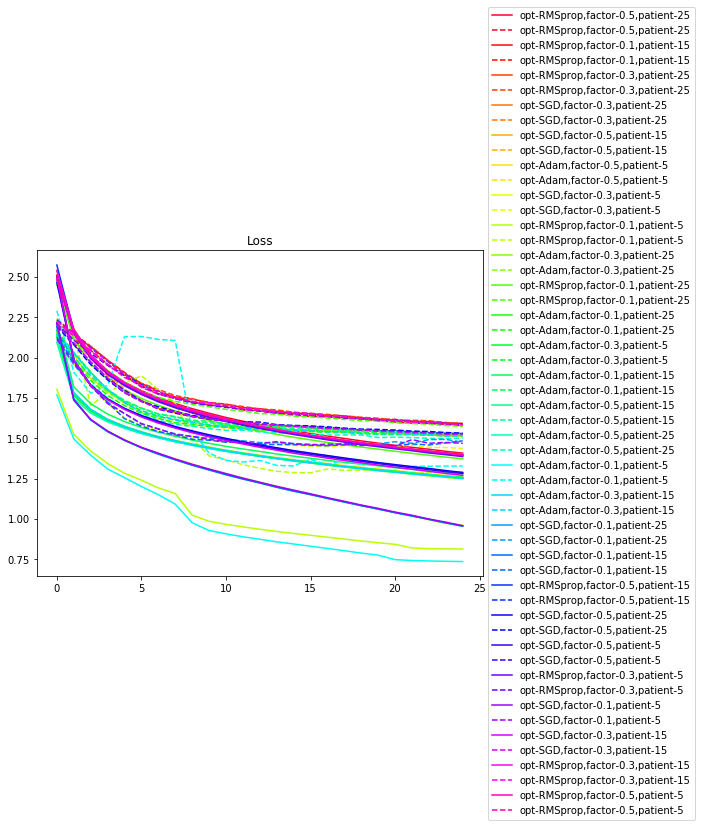

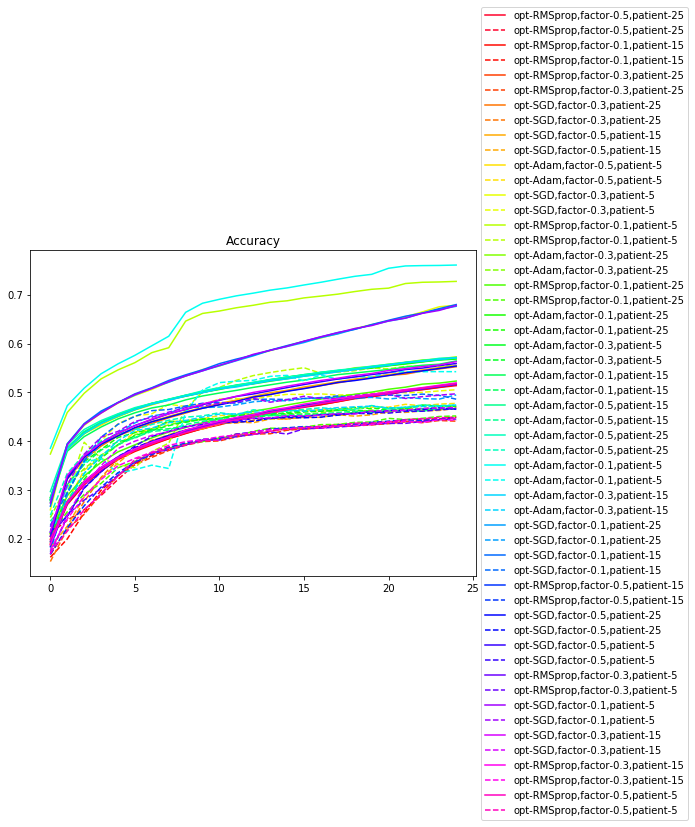

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()